In [30]:
import lbg_forecast.sps as sps
import lbg_forecast.sfh as sfh
import lbg_forecast.cosmology as cosmo
import lbg_forecast.emulator as em
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sps_model=sps.initialise_sps_model(neb_em=False)

In [24]:
redshift=np.arange(0.01, 7.0, 0.5)
phot1 = []
phot9 = []
for z in redshift:
    sps_params = np.array([z, 0.0, 0.1, 0.1, 0.0, 1.0, -2, 0.0, -2, 10, 0, 0, 0, 0, 0, 0, 10**9])
    sps.update_model(sps_model, sps_params, False, sfh.default_agebins())
    phot9.append(sps.get_magnitudes(sps_model, filters="lsst", cosmology=cosmo.get_wmap9(), lya_uncertainity=False, path="./"))
    phot1.append(sps.get_magnitudes(sps_model, filters="lsst", cosmology=cosmo.get_wmap1(), lya_uncertainity=False, path="./"))

phot1 = np.array(phot1)
phot9 = np.array(phot9)


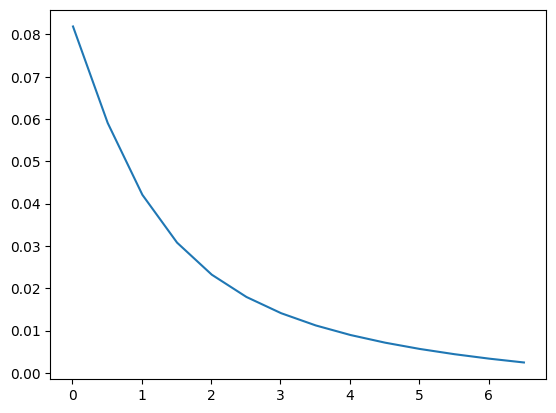

In [69]:
diff = (phot9-phot1)[:, 0]
plt.plot(redshift, diff)

In [101]:
mimic = em.fsps_emulator("./")

sps_params = np.array([0.01, 0.1, 0.5, 0.1, 0.0, 1.0, -3, 0.0, 10**-2, 10, -1, -1, 0, -1, -1, -1, 10**8])
sps_param_resize = sps_params.reshape((1, sps_params.shape[0]))


photem = mimic.mimic_photometry(sps_param_resize, 1)
sps.update_model(sps_model, sps_params, False, sfh.default_agebins())
photo9 = sps.get_magnitudes(sps_model, filters="lsst", cosmology=cosmo.get_wmap9(), lya_uncertainity=False, path="./")
photo1 = sps.get_magnitudes(sps_model, filters="lsst", cosmology=cosmo.get_wmap1(), lya_uncertainity=False, path="./")

print(photem[0][0]+diff[0], photo1[0]+diff[0], photo9[0])

22.2301171822282 22.37398375382875 22.373983753828753
